<a href="https://colab.research.google.com/github/jeelkukadiya/CodSoft-internship_ML/blob/main/Task_3_Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bank-customer-churn-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2008274%2F3322096%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240601%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240601T113617Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D40aba4710ad71833b18d907afc8ac148a901783d48f5dd850a482c6dea00543d82ded7afdee358709f466729b845330bf9eb1466f41d6897308164c792709f9eb2ddda6f5c44c9f51e7fa6b61027d80f13f672814ed694ad0d661ed0b2e3306cbb4bad23940eafa852d9997050ecb2a6a0a4482091040fe454ae7b28a072c7ec760197cabaffe55a80f28c836f1f5775dc90b08772dce6e97522cea2695d3f65a733ba65dd7b078b7fae52b2c632f828837f51e21e395b8a83f0d7e44093037678b1553c7bedfbcdd4fc513a4c9808ef6215e00ec7d8f3a4060614fd39561df3be135009c5d8754a8e69a9105875d8c7ba7d3c830109c6f2a5dec6f41c7ff99f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 267794 bytes downloaded
Downloaded and uncompressed: bank-customer-churn-prediction
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv


In [3]:
df = pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv")

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.drop(columns = ['CustomerId','Surname','RowNumber'],inplace=True)

In [6]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [8]:
df['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [9]:
df = pd.get_dummies(df,columns=['Geography','Gender'],drop_first=True)

In [10]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


In [11]:
X = df.drop(columns=['Exited'])
y = df['Exited']

In [12]:
X.shape

(10000, 11)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
X_train.shape

(8000, 11)

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_trf = scaler.fit_transform(X_train)
X_test_trf = scaler.fit_transform(X_test)

In [16]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [17]:
model = Sequential()
model.add(Dense(11,activation='sigmoid',input_dim=11))
model.add(Dense(11,activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                132       
                                                                 
 dense_1 (Dense)             (None, 11)                132       
                                                                 
 dense_2 (Dense)             (None, 1)                 12        
                                                                 
Total params: 276 (1.08 KB)
Trainable params: 276 (1.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [20]:
history = model.fit(X_train_trf,y_train,batch_size=50,epochs=100,verbose=1,validation_split=0.2)

Epoch 1/100
128/128 [==============================] - 4s 10ms/step - loss: 0.5749 - accuracy: 0.7631 - val_loss: 0.5061 - val_accuracy: 0.7969
Epoch 2/100
128/128 [==============================] - 1s 7ms/step - loss: 0.4934 - accuracy: 0.7958 - val_loss: 0.4844 - val_accuracy: 0.7969
Epoch 3/100
128/128 [==============================] - 1s 8ms/step - loss: 0.4790 - accuracy: 0.7958 - val_loss: 0.4729 - val_accuracy: 0.7969
Epoch 4/100
128/128 [==============================] - 1s 7ms/step - loss: 0.4669 - accuracy: 0.7958 - val_loss: 0.4614 - val_accuracy: 0.7969
Epoch 5/100
128/128 [==============================] - 1s 5ms/step - loss: 0.4549 - accuracy: 0.7958 - val_loss: 0.4511 - val_accuracy: 0.7969
Epoch 6/100
128/128 [==============================] - 1s 5ms/step - loss: 0.4445 - accuracy: 0.7956 - val_loss: 0.4430 - val_accuracy: 0.7975
Epoch 7/100
128/128 [==============================] - 1s 4ms/step - loss: 0.4367 - accuracy: 0.7983 - val_loss: 0.4376 - val_accuracy: 0.805

In [21]:
y_pred = model.predict(X_test_trf)

63/63 [==============================] - 0s 1ms/step


In [22]:
y_pred

array([[0.19872198],
       [0.29471746],
       [0.118342  ],
       ...,
       [0.06741151],
       [0.10258147],
       [0.19513397]], dtype=float32)

In [23]:
y_pred = y_pred.argmax(axis=-1)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.7975

In [25]:
import matplotlib.pyplot as plt

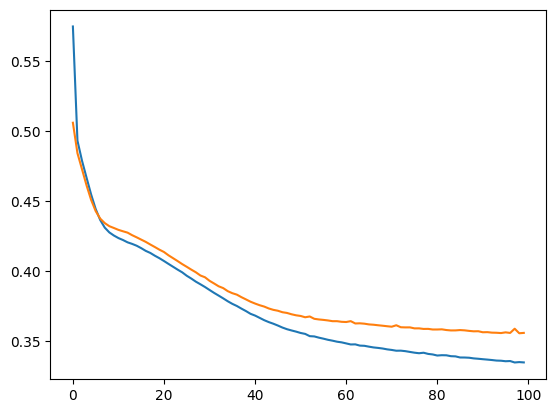

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

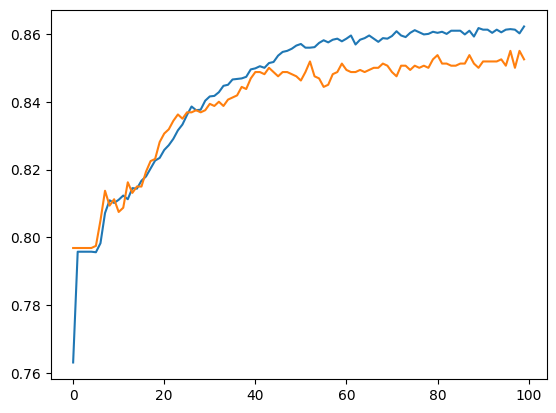

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])